# Results Analysis

## Utils link

- [Multi Label Model Evaluation](https://www.kaggle.com/code/kmkarakaya/multi-label-model-evaluation)

## Code prepare

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score, multilabel_confusion_matrix, classification_report, accuracy_score, jaccard_score, f1_score
import os
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use([s for s in plt.style.available if 'whitegrid' in s][0])
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100

### Utils functions

In [3]:
def list_folders(path):
    # Check if the path exists
    if not os.path.exists(path):
        return "The specified path does not exist."

    # Get a list of all items in the path
    contents = os.listdir(path)

    # Filter only the folders
    folders = [item for item in contents if os.path.isdir(os.path.join(path, item))]

    return folders

def experiments(name:str):
    experiments = [
        ('exp0', 'all'),
        ('exp1', 'diagnostic'),
        ('exp1.1', 'subdiagnostic'),
        ('exp1.1.1', 'superdiagnostic'),
        ('exp2', 'form'),
        ('exp3', 'rhythm')
       ]
    for exp in experiments:
        if name == exp[0]:
            return exp[1]

### Variables

In [4]:
experiments = {
        'exp0': 'all',
        'exp1': 'diagnostic',
        'exp1.1': 'subdiagnostic',
        'exp1.1.1': 'superdiagnostic',
        'exp2': 'form',
        'exp3': 'rhythm'
       }

datas = {
"test": None, 
"train": None, 
"val": None
}

predictions = {
"test": None, 
"train": None, 
"val": None
}

path = "./output/"

threshold = 0.5

## Analysis

In [5]:
for exp in list_folders(path):
    print("_"*100)
    print(exp)
    for dt in datas:
        datas[dt] = np.load(f'{path}/{exp}/data/y_{dt}.npy', allow_pickle=True)
    for model in list_folders(f'{path}/{exp}/models'):
        print(f'\n\t{model}')
        for pred in predictions:
            predictions[pred] = np.load(f'{path}/{exp}/models/{model}/y_{pred}_pred.npy', allow_pickle=True)
            print(f'\t\t{pred}')
            print(f'\t\t\t- Shape: {predictions[pred].shape}')
            print(f'\t\t\t- Binary values: {len(np.unique(predictions[pred]))==2}')
            print(f'\t\t\t- Min value: {np.min(predictions[pred])}')
            print(f'\t\t\t- Max value: {np.max(predictions[pred])}')
            print(f'\t\t\t- Range 0-1: {(np.min(predictions[pred]) >= 0) and (np.max(predictions[pred]) <= 1)}')
            


    print("\n\n")

____________________________________________________________________________________________________
exp0

	ensemble
		test
			- Shape: (2198, 71)
			- Binary values: False
			- Min value: 2.9390854194843996e-09
			- Max value: 0.9997862577438354
			- Range 0-1: True
		train
			- Shape: (17418, 71)
			- Binary values: False
			- Min value: 3.694129691814846e-13
			- Max value: 0.9999032020568848
			- Range 0-1: True
		val
			- Shape: (2183, 71)
			- Binary values: False
			- Min value: 1.2285740202955253e-09
			- Max value: 0.9995032548904419
			- Range 0-1: True

	fastai_xresnet1d101
		test
			- Shape: (2198, 71)
			- Binary values: False
			- Min value: 2.8333084581582304e-18
			- Max value: 0.999968409538269
			- Range 0-1: True
		train
			- Shape: (17418, 71)
			- Binary values: False
			- Min value: 0.0
			- Max value: 0.9999884366989136
			- Range 0-1: True
		val
			- Shape: (2183, 71)
			- Binary values: False
			- Min value: 1.0596432834963816e-18
			- Max value: 0.999904513359

## Metrics

In [6]:
results = []

res = {}

for exp in sorted(list_folders(path)):
    res[exp] = {}
    for dt in datas:
        datas[dt] = np.load(f'{path}/{exp}/data/y_{dt}.npy', allow_pickle=True)
    res[exp]["data"] = datas.copy()
    for model in list_folders(f'{path}/{exp}/models'):
        for pred in predictions:
            predictions[pred] = np.load(f'{path}/{exp}/models/{model}/y_{pred}_pred.npy', allow_pickle=True)
            res[exp][model]=predictions.copy()

            # AUC score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "AUC",
                "set": pred,
                "value": roc_auc_score(datas[pred], predictions[pred], average="weighted")
            })

            # Accuracy score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "Accuracy",
                "set": pred,
                "value": accuracy_score(datas[pred], (predictions[pred]>threshold))
            })

            # Jaccard score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "Jaccard",
                "set": pred,
                "value": jaccard_score(datas[pred], (predictions[pred]>threshold), average="weighted")
            })

            # F1-score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "F1",
                "set": pred,
                "value": f1_score(datas[pred], (predictions[pred]>threshold), average="weighted")
            })

            # Precision score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "Precision",
                "set": pred,
                "value": metrics.precision_score(datas[pred], (predictions[pred]>threshold), average="weighted")
            })

            # Recall score
            results.append({
                "experiment" : experiments[exp],
                "model" : model,
                "metric" : "Recall",
                "set": pred,
                "value": metrics.recall_score(datas[pred], (predictions[pred]>threshold), average="weighted")
            })

results = pd.DataFrame(results)
results

,experiment,model,metric,set,value
0,all,ensemble,AUC,test,0.916652
1,all,ensemble,Accuracy,test,0.392630
2,all,ensemble,Jaccard,test,0.564024
3,all,ensemble,F1,test,0.662292
4,all,ensemble,Precision,test,0.701264
...,...,...,...,...,...
391,subdiagnostic,fastai_resnet1d_wang,Accuracy,val,0.526561
392,subdiagnostic,fastai_resnet1d_wang,Jaccard,val,0.544909
393,subdiagnostic,fastai_resnet1d_wang,F1,val,0.676185
394,subdiagnostic,fastai_resnet1d_wang,Precision,val,0.667169


In [7]:
results[(results["experiment"]=="all") & (results["metric"]=="AUC") & (results["set"]=="test")]

,experiment,model,metric,set,value
0,all,ensemble,AUC,test,0.916652
18,all,fastai_xresnet1d101,AUC,test,0.916907
36,all,fastai_lstm,AUC,test,0.904195
54,all,Wavelet+NN,AUC,test,0.853179
72,all,naive,AUC,test,0.500000
90,all,fastai_inception1d,AUC,test,0.912341
108,all,fastai_fcn_wang,AUC,test,0.905179
126,all,fastai_resnet1d_wang,AUC,test,0.910896
144,all,fastai_lstm_bidir,AUC,test,0.907127


In [8]:
results[(results["experiment"]=="diagnostic") & (results["metric"]=="Accuracy") & (results["set"]=="test")]

,experiment,model,metric,set,value
163,diagnostic,ensemble,Accuracy,test,0.544486
181,diagnostic,fastai_xresnet1d101,Accuracy,test,0.530584
199,diagnostic,fastai_lstm,Accuracy,test,0.524096
217,diagnostic,Wavelet+NN,Accuracy,test,0.418906
235,diagnostic,naive,Accuracy,test,0.000000
253,diagnostic,fastai_inception1d,Accuracy,test,0.517146
271,diagnostic,fastai_fcn_wang,Accuracy,test,0.530120
289,diagnostic,fastai_resnet1d_wang,Accuracy,test,0.531047
307,diagnostic,fastai_lstm_bidir,Accuracy,test,0.525023


## Baseline MI vs NORM

In [9]:
agg_df = pd.read_csv(f'{path}../data/ptbxl/scp_statements.csv')
print(agg_df.shape)
agg_df.head()

(71, 13)


,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
0,NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
1,NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
2,DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
3,LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
4,NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [20]:
agg_df[agg_df.diagnostic_class == "MI"]

,Unnamed: 0,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
5,IMI,inferior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferior myocardial infarction,161.0,NaN,NaN,NaN
6,ASMI,anteroseptal myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anteroseptal myocardial infarction,165.0,NaN,NaN,NaN
16,ILMI,inferolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferolateral myocardial infarction,NaN,NaN,NaN,NaN
18,AMI,anterior myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterior myocardial infarction,160.0,NaN,NaN,NaN
19,ALMI,anterolateral myocardial infarction,1.0,NaN,NaN,MI,AMI,Myocardial Infarction,anterolateral myocardial infarction,NaN,NaN,NaN,NaN
21,INJAS,subendocardial injury in anteroseptal leads,1.0,NaN,NaN,MI,AMI,ischemic ST-T changes compatible with subendoc...,in anteroseptal leads,NaN,NaN,NaN,NaN
22,LMI,lateral myocardial infarction,1.0,NaN,NaN,MI,LMI,Myocardial Infarction,lateral myocardial infarction,163.0,NaN,NaN,NaN
26,INJAL,subendocardial injury in anterolateral leads,1.0,NaN,NaN,MI,AMI,ischemic ST-T changes compatible with subendoc...,in anterolateral leads,NaN,NaN,NaN,NaN
34,IPLMI,inferoposterolateral myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterolateral myocardial infarction,NaN,NaN,NaN,NaN
36,IPMI,inferoposterior myocardial infarction,1.0,NaN,NaN,MI,IMI,Myocardial Infarction,inferoposterior myocardial infarction,NaN,NaN,NaN,NaN


In [19]:
baseline = {}
diagnosis = {
    "MI": None,
    "NORM": None
    }
exp = "exp0"
model = "data"

# find diagnostic index
dia_glob = []
for dia in diagnosis:
    diagnosis[dia] = agg_df.diagnostic_class == dia
    diagnosis[dia] = np.where(diagnosis[dia])[0]
    dia_glob.extend(diagnosis[dia])

dia_glob = sorted(dia_glob)
for dia in diagnosis:
    diagnosis[dia] = [dia_glob.index(idx) for idx in diagnosis[dia]]



y = {}
for set in res[exp][model]:
    y[set] = {}
    for dia in diagnosis:
        y[set][dia] = np.any((res[exp][model][set][:, agg_df.diagnostic_class == dia]), axis=1).astype(int)
        print(f'{set} - {dia} {np.sum(y[set][dia])}/{len(y[set][dia])}')

y

test - MI 618/2198
test - NORM 152/2198
train - MI 4970/17418
train - NORM 1211/17418
val - MI 602/2183
val - NORM 151/2183


{'test': {'MI': array([0, 0, 0, ..., 0, 1, 1]),
  'NORM': array([0, 0, 0, ..., 0, 0, 0])},
 'train': {'MI': array([0, 0, 0, ..., 0, 0, 0]),
  'NORM': array([0, 0, 0, ..., 0, 0, 0])},
 'val': {'MI': array([1, 0, 1, ..., 0, 0, 0]),
  'NORM': array([0, 0, 1, ..., 0, 0, 0])}}

In [ ]:
res[exp][model][set]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
baseline = {}
diagnosis = {
    "MI": None,
    "NORM": None
    }
exp = "exp0"
model = "data"

# find diagnostic index
dia_glob = []
for dia in diagnosis:
    diagnosis[dia] = agg_df.diagnostic_class == dia
    diagnosis[dia] = np.where(diagnosis[dia])[0]
    dia_glob.extend(diagnosis[dia])

dia_glob = sorted(dia_glob)
for dia in diagnosis:
    diagnosis[dia] = [dia_glob.index(idx) for idx in diagnosis[dia]]

# prepare baseline
for model in res[exp]:
    baseline[model] = {}
    for set in res[exp][model]:
        baseline[model][set] = res[exp][model][set][:, (agg_df.diagnostic_class.isin(diagnosis.keys()))]

# prepare target
y = baseline.pop("data")
for set in y:
    tmp = []
    for dia in diagnosis:
        tmp.append(np.any(y[set][:, diagnosis[dia]], axis=1).astype(int))
    y[set] = np.transpose(np.array(tmp))

{'data': {'test': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'train': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'val': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [1, 1, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])},
 'ensemble': {'test': array([[3.2832574e-03, 2.7107415e-05, 1.3455885e-03, ..., 5.6784734e-04,
          7.7586701e-05, 1.4533865e-03],
         [4.5385226e-04, 2.1217356e-05, 3.0632692e-03, ..., 1.0005583e-03,
          1.3745611e-03, 3.1160873e-03],
         [8.3570217e-04, 5.3431741e-05, 2.8547677e-04, 

In [ ]:


model = "data"
y = {}
# prepare baseline
for set in res[exp][model]:
        y[set] = []
        for dia in diagnosis:
            y[set].append(np.any(res[exp][model][set][:, diagnosis[dia]], axis=1).astype(int))
        y[set] = np.transpose(np.array(y[set]))
# first count of elements
counts = {'Dataset': [], 'NORM': [], 'MI': []}

for dataset, values in y.items():
    mi_count = np.sum(values[:, 0])
    norm_count = np.sum(values[:, 1])
    counts['Dataset'].append(dataset)
    counts['NORM'].append(norm_count)
    counts['MI'].append(mi_count)

df2 = pd.DataFrame(counts)

df2.set_index('Dataset', inplace=True)
df2

,NORM,MI
Dataset,,
test,79,659
train,634,5345
val,80,681


In [ ]:
df2

,NORM,MI
Dataset,,
test,152,618
train,1211,4970
val,151,602


In [ ]:
baseline = {}
diagnosis = {
    "MI": None,
    "NORM": None
    }
exp = "exp0"

# find diagnostic index
dia_glob = []
for dia in diagnosis:
    diagnosis[dia] = agg_df.diagnostic_class == dia
    diagnosis[dia] = np.where(diagnosis[dia])[0]
    dia_glob.extend(diagnosis[dia])

dia_glob = sorted(dia_glob)
for dia in diagnosis:
    diagnosis[dia] = [dia_glob.index(idx) for idx in diagnosis[dia]]

# prepare baseline
for model in res[exp]:
    baseline[model] = {}
    for set in res[exp][model]:
        baseline[model][set] = res[exp][model][set][:, (agg_df.diagnostic_class.isin(diagnosis.keys()))]

# prepare target
y = baseline.pop("data")
for set in y:
    tmp = []
    for dia in diagnosis:
        tmp.append(np.any(y[set][:, diagnosis[dia]], axis=1).astype(int))
    y[set] = np.transpose(np.array(tmp))


# find utils rows
utils = {}
for set in y:
    utils[set] = np.sum(y[set], axis=1) == 1

# prepare prediction values
for model in baseline:
    for set in baseline[model]:
        baseline[model][set] = np.where(np.isin(np.argmax(baseline[model][set], axis = 1), diagnosis["MI"]), 1, 0)

# keep only utils rows in predictions
for model in baseline:
    for set in baseline[model]:
        baseline[model][set] = baseline[model][set][utils[set]]


# first count of elements
counts = {'Dataset': [], 'NORM': [], 'MI': []}

for dataset, values in y.items():
    mi_count = np.sum(values[:, 0])
    norm_count = np.sum(values[:, 1])
    counts['Dataset'].append(dataset)
    counts['NORM'].append(norm_count)
    counts['MI'].append(mi_count)

df2 = pd.DataFrame(counts)

df2.set_index('Dataset', inplace=True)

# keep only utils rows in target & prepare it
for set in y:
    y[set] = y[set][utils[set]]
    y[set] = y[set][:, 0]

In [ ]:
model = "naive"
for set in baseline[model]:
    print(f'{set} - {np.sum(baseline[model][set])} / {len(baseline[model][set])}')

test - 608 / 608
train - 5057 / 5057
val - 597 / 597


In [ ]:
for set in y:
    print(f'{set} - {np.sum(y[set])} / {len(y[set])}')

test - 537 / 608
train - 4408 / 5057
val - 524 / 597


In [ ]:
base_res = []

for model in baseline:
    for set in baseline[model]:

        # AUC score
        base_res.append({
            "model" : model,
            "metric" : "AUC",
            "set": set,
            "value": roc_auc_score(y[set], baseline[model][set], average="weighted")
        })

        # Accuracy score
        base_res.append({
            "model" : model,
            "metric" : "Accuracy",
            "set": set,
            "value": accuracy_score(y[set], baseline[model][set])
        })

        # Jaccard score
        base_res.append({
            "model" : model,
            "metric" : "Jaccard",
            "set": set,
            "value": jaccard_score(y[set], baseline[model][set], average="weighted")
        })

        # F1-score
        base_res.append({
            "model" : model,
            "metric" : "F1",
            "set": set,
            "value": f1_score(y[set], baseline[model][set], average="weighted")
        })

        # Precision score
        base_res.append({
            "model" : model,
            "metric" : "Precision",
            "set": set,
            "value": metrics.precision_score(y[set], baseline[model][set], average="weighted")
        })

        # Recall score
        base_res.append({
            "model" : model,
            "metric" : "Recall",
            "set": set,
            "value": metrics.recall_score(y[set], baseline[model][set], average="weighted")
        })

base_res = pd.DataFrame(base_res)
base_res

,model,metric,set,value
0,ensemble,AUC,test,0.934469
1,ensemble,Accuracy,test,0.949013
2,ensemble,Jaccard,test,0.911868
3,ensemble,F1,test,0.951563
4,ensemble,Precision,test,0.957332
...,...,...,...,...
157,fastai_lstm_bidir,Accuracy,val,0.946399
158,fastai_lstm_bidir,Jaccard,val,0.908063
159,fastai_lstm_bidir,F1,val,0.949554
160,fastai_lstm_bidir,Precision,val,0.957681


In [ ]:
counts = {'Dataset': [], 'NORM': [], 'MI': []}

for dataset, values in y.items():
    norm_count = sum(values == 0)
    mi_count = sum(values == 1)
    counts['Dataset'].append(dataset)
    counts['NORM'].append(norm_count)
    counts['MI'].append(mi_count)

df = pd.DataFrame(counts)

df.set_index('Dataset', inplace=True)

df

,NORM,MI
Dataset,,
test,71,537
train,649,4408
val,73,524


In [ ]:
df2

,NORM,MI
Dataset,,
test,152,618
train,1211,4970
val,151,602


In [ ]:
np.sum(df2)

NORM    1514
MI      6190
dtype: int64

In [ ]:
np.sum(np.sum(df2))

7704

<Axes: title={'center': 'Class Distribution in the Datasets'}, xlabel='Dataset'>

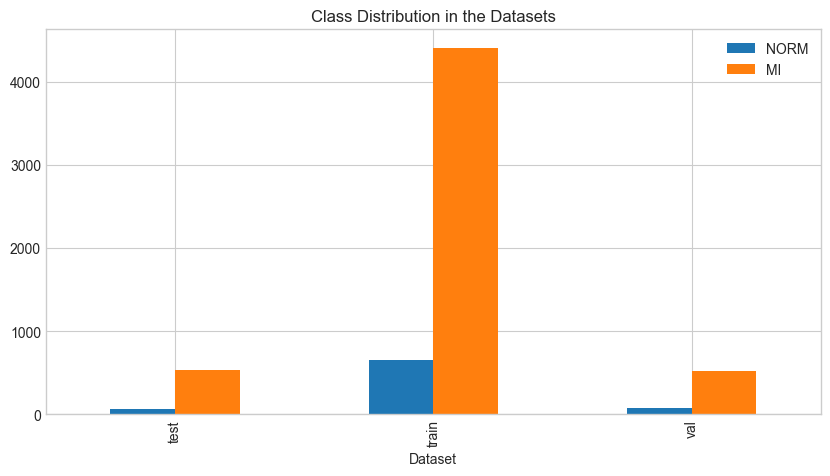

In [ ]:
df.plot(kind='bar', stacked=False, figsize=(10, 5), title='Class Distribution in the Datasets')